In [1]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as npP
from natsort import natsorted
from PIL import Image
import random
import pickle

In [ ]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

import zipfile

path_to_zip_file = 'drive/MyDrive/data.zip'
directory_to_extract_to = 'VISCHEMA_PLUS/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

!cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
!cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"

In [9]:
# Create datasets and dataloaders

import pandas as pd

class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


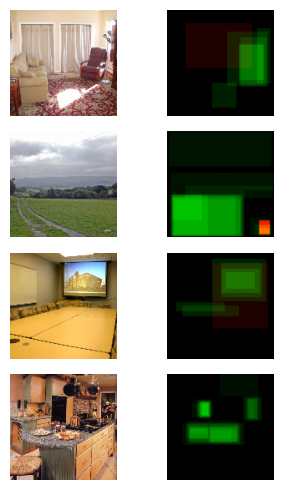

In [6]:
# Examine some image label pairs

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [3]:
# Generator Model

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, _ = next(iter(train_loader))
output = model(images)

print(output.shape)

del model, output, images

31031875 Parameters in UNet Generator
torch.Size([1, 3, 128, 128])


In [4]:
# Discriminator Model

class Discriminator(nn.Module):
    def __init__(self, norm_func = nn.BatchNorm2d, channels = (6,64,128,256,512,1024)):
        super(Discriminator, self).__init__()
        
        def Block(in_channels, out_channels, norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(norm_func(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *Block(channels[0],channels[1], norm = False),
            *Block(channels[1],channels[2]),
            *Block(channels[2],channels[3]),
            *Block(channels[3],channels[4]),
            *Block(channels[4],channels[5]),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(channels[5],1,4,padding=1, bias=False)
        )
        
    def forward(self, images, labels):
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

11169472 Parameters in Discriminator
torch.Size([1, 1, 4, 4])


In [5]:
#  Set up training environment variables

norm_functions_g = [nn.BatchNorm2d, nn.InstanceNorm2d, nn.LayerNorm]
norm_functions_d = [nn.BatchNorm2d, nn.InstanceNorm2d]

generator_channels = [
    {'encode':(3,64 ,128,256,512,1024) , 'decode':(1024,512,256,128,64 )},
    {'encode':(3,32 ,64 ,128,256,512 ) , 'decode':(512 ,256,128,64 ,32 )},
    {'encode':(3,50 ,100,200,400,800 ) , 'decode':(800 ,400,200,100,50 )},
    {'encode':(3,100,200,400,800,1600) , 'decode':(1600,800,400,200,100)}
]
discriminator_channels = [
    (6,64 ,128,256,512,1024),
    (6,32 ,64 ,128,256,512 ),
    (6,50 ,100,200,400,800 ),
    (6,100,200,400,800,1600),
]
generator_optimisers = [
    torch.optim.Adam,
    torch.optim.Adadelta,
    torch.optim.SGD
]
discriminator_optimisers = generator_optimisers[:]

learning_rates = [0.0001,0.0005,0.001,0.00005,0.0002,0.005,1,0.5,0.25,0.1,0.01,0.001, 0.005]

adam_betas = [(0.9, 0.999), (0, 0.999), (0.5, 0.999)]

In [10]:
def train_GAN(
    generator, 
    discriminator,
    optim_g,
    optim_d,
    save_dir):

    ###################################
    # Set up our training environment #
    ###################################

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator, discriminator = generator.to(device), discriminator.to(device)

    patch = (1, 4, 4)

    criterion_GAN = nn.MSELoss()
    criterion_pixelwise = nn.L1Loss() 

    train_losses = []
    val_losses = []
    best_val_loss = 1000000

    # Loss weight of L1 pixel-wise loss between translated image and real image
    # This value is copied from the PIX2PIX architecture
    lambda_pixel = 100
    num_epochs = 100
    
    #######################
    # Start Training Loop #
    #######################

    print(f'Starting Training for {save_dir}')
    for epoch in range(num_epochs):

        # Go into training mode
        discriminator.train()
        generator.train()

        # Train the model and evaluate on the training set
        total_train_loss = 0
        total_val_loss = 0

        for i, (images, real_labels) in enumerate(train_loader):

            # Adversarial ground truths
            valid = torch.ones((images.size(0), *patch)).to(device)
            fake = torch.zeros((images.size(0), *patch)).to(device)

            # Move images to device and create an image prediction
            images, real_labels = images.to(device), real_labels.to(device)

            ###################
            # Train Generator #
            ###################

            optim_g.zero_grad()

            # GAN Loss

            fake_labels = generator(images)
            pred_fake = discriminator(fake_labels, images)
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_pixel = criterion_pixelwise(fake_labels, real_labels)

            # Logging
            batch_loss = loss_pixel.item() * batch_size
            total_train_loss += batch_loss

            loss_G = loss_GAN + lambda_pixel * loss_pixel

            loss_G.backward()
            optim_g.step()

            #######################
            # Train Discriminator #
            #######################

            optim_d.zero_grad()

            # Real Loss
            pred_real = discriminator(real_labels, images)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake Loss
            pred_fake = discriminator(fake_labels.detach(), images)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total Loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optim_d.step()

            # Clear memory
            del images, real_labels, fake_labels 
            torch.cuda.empty_cache() 

        generator.eval()
        with torch.no_grad():
          for i, (images, real_labels) in enumerate(val_loader):

              # Adversarial ground truths
              valid = torch.ones((images.size(0), *patch)).to(device)
              fake = torch.zeros((images.size(0), *patch)).to(device)

              # Move images to device and create an image prediction
              images, real_labels = images.to(device), real_labels.to(device)

              #########################
              # Test Generator On Val #
              #########################

              # GAN Loss

              fake_labels = generator(images)
              loss_pixel = criterion_pixelwise(fake_labels, real_labels)
              batch_loss = loss_pixel.item() * batch_size
              total_val_loss += batch_loss

              # Clear memory
              del images, real_labels, fake_labels 
              torch.cuda.empty_cache() 

        train_losses.append( total_train_loss/ len(train_loader))
        val_losses.append( total_val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(discriminator.state_dict(), f'weights/{save_dir}-NETD-best.pkl')
            torch.save(generator.state_dict(), f'weights/{save_dir}-NETG-best.pkl')

    # Use pickle to save the list of train/val losses
    # This will allow us to analyse them later
    save_list_to_file(val_losses  , f'losses/{save_dir}-val_losses')
    save_list_to_file(train_losses, f'losses/{save_dir}-train_losses')

    return best_val_loss

def save_list_to_file(list_to_save, filename):
    with open(filename, 'wb') as fp:
        pickle.dump(list_to_save, fp)

def read_list_from_file(filename):
    with open(filename, 'rb') as fp:
        list_read = pickle.load(fp)
        return list_read

def log(string_to_log):
    file = open("log.txt", "a")
    file.write(f"{string_to_log} \n")
    file.close()

In [8]:
# Test training with different variables

# Iterating over every parameter combination would be ideal but it would also require an insane amount of runs. O(N^2)
# Instead we will iterate over every parameter, pick the one that gives the best result and go through each option until we find the best O(N)
# i.e. 10s of tests rather than 1000s

iteration_counter = 0
iteration_dictionary = {}

# Test Norm Functions
best_norm_func_d = None
best_norm_func_g = None
best_norm_score = 100000000
for (norm_func_d,norm_func_g) in [(norm_func_d, norm_func_g) for norm_func_d in norm_functions_d for norm_func_g in norm_functions_g]:
    
    # Set up environment
    generator = Generator(norm_func = norm_func_d)
    discriminator = Discriminator(norm_func = norm_func_d)
    optim_g = torch.optim.Adam(generator.parameters())
    optim_d = torch.optim.Adam(discriminator.parameters())
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Discriminator Norm Func = {norm_func_d}, Generator Norm Func = {norm_func_g}" 
    
    # train with each norm function combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Norm Func Generator = {norm_func_g}, Discriminator = {norm_func_d}, val_score = {val_score}")

    if val_score < best_norm_score:
        best_norm_func_g = norm_func_g
        best_norm_func_d = norm_func_d
        best_norm_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Channels
best_generator_channels_pair = None
best_discrminator_channels = None
best_channel_score = 100000000
for (g, d) in [(g,d) for g in generator_channels for d in discriminator_channels]:
    
    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=g['decode'], encode_channels=g['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=d)
    optim_g = torch.optim.Adam(generator.parameters())
    optim_d = torch.optim.Adam(discriminator.parameters())
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen Channels = {g}, Disc Channels = {d}" 
    
    # train with each channel combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen Channels = {g}, Disc Channels = {d}, Val = {val_score}")

    if val_score < best_channel_score:
        best_generator_channels_pair = g
        best_discrminator_channels = d
        best_channel_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Optim Functions
best_optim_g = None
best_optim_d = None
best_optim_score = 100000000
for (g,d) in [(g,d) for g in generator_optimisers for d in discriminator_optimisers]:
    
    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
    
    if g == torch.optim.SGD:
        optim_g = g(generator.parameters(), lr=0.01)
    else:  
        optim_g = g(generator.parameters())
        
    if d == torch.optim.SGD:
        optim_d = d(discriminator.parameters(), lr=0.01)
    else:
        optim_d = d(discriminator.parameters())
        
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen optim = {g}, Disc optim = {d}" 
    
    # train with each optim combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen optim = {g}, Disc optim = {d}, Val = {val_score}")

    if val_score < best_channel_score:
        best_optim_g = g
        best_optim_d = d
        best_optim_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Learning Rates
best_LR_g = None
best_LR_d = None
best_LR_score = 100000000000
for (LR_g, LR_d) in [(LR_g, LR_d) for LR_g in learning_rates for LR_d in learning_rates]:

    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
    optim_g = g(generator.parameters(), lr=LR_g)
    optim_d = d(discriminator.parameters(), lr=LR_d)
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen LR = {LR_g}, Disc LR = {LR_d}" 
    
    # train with each optim combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen LR = {LR_g}, Disc LR = {LR_d}, Val = {val_score}")

    if val_score < best_LR_score:
        best_LR_g = LR_g
        best_LR_d = LR_d
        best_LR_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Adam Betas
if (best_optim_g == torch.optim.Adam or best_optim_d == torch.optim.Adam):
    best_Adam_Betas_g = None
    best_Adam_Betas_d = None
    best_betas_score  = 100000000
    for (g,d) in [(g,d) for g in adam_betas for d in adam_betas]:
        # Set up environment
        generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
        discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
        optim_g = g(generator.parameters(), lr=best_LR_g, betas=g)
        optim_d = d(discriminator.parameters(), lr=best_LR_d, betas=d)
        save_dir = iteration_counter
        iteration_dictionary[iteration_counter] = f"Gen Adam Betas = {g}, Disc Adam Betas = {d}" 
        
        # train with each beta combo
        val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

        log(f"Gen adam beta = {g}, Disc adam beta = {d}, Val = {val_score}")

        if val_score < best_betas_score:
            best_Adam_Betas_g = g
            best_Adam_Betas_d = d
            best_betas_score = val_score

        # Increment Counter
        iteration_counter += 1

Starting Training for 0
Epoch [1/1], D: 0.6058, G: 101.6433,  Val Loss: 7.255127906799316 Train Loss: 8.050976753234863
Starting Training for 1
Epoch [1/1], D: 0.6485, G: 96.3606,  Val Loss: 6.857418060302734 Train Loss: 7.6085524559021
Starting Training for 2
Epoch [1/1], D: 0.8336, G: 102.9997,  Val Loss: 7.266326904296875 Train Loss: 8.113276481628418
Starting Training for 3
Epoch [1/1], D: 0.5252, G: 100.3830,  Val Loss: 7.070572853088379 Train Loss: 7.955026149749756
Starting Training for 4
Epoch [1/1], D: 0.4444, G: 95.4167,  Val Loss: 6.747488975524902 Train Loss: 7.5576982498168945
Starting Training for 5
Epoch [1/1], D: 0.6626, G: 99.7609,  Val Loss: 7.405026435852051 Train Loss: 7.87916898727417
Starting Training for 6
Epoch [1/1], D: 0.5804, G: 99.2257,  Val Loss: 7.138533592224121 Train Loss: 7.861810207366943
Starting Training for 7
Epoch [1/1], D: 0.5346, G: 108.1079,  Val Loss: 7.75862979888916 Train Loss: 8.571308135986328
Starting Training for 8
Epoch [1/1], D: 0.6791,

Starting Training for 69
Epoch [1/1], D: 0.5900, G: 101.1843,  Val Loss: 7.116250514984131 Train Loss: 8.005151748657227
Starting Training for 70
Epoch [1/1], D: 0.8145, G: 102.8197,  Val Loss: 7.234721660614014 Train Loss: 8.114741325378418
Starting Training for 71
Epoch [1/1], D: 0.5756, G: 99.0952,  Val Loss: 7.374413967132568 Train Loss: 7.836678981781006
Starting Training for 72
Epoch [1/1], D: 0.5915, G: 104.5075,  Val Loss: 7.581979274749756 Train Loss: 8.269147872924805
Starting Training for 73
Epoch [1/1], D: 0.5709, G: 95.3221,  Val Loss: 6.668710231781006 Train Loss: 7.534781455993652
Starting Training for 74
Epoch [1/1], D: 0.7799, G: 102.8675,  Val Loss: 7.370538234710693 Train Loss: 8.102684020996094
Starting Training for 75
Epoch [1/1], D: 0.7946, G: 98.8385,  Val Loss: 7.1734418869018555 Train Loss: 7.791228294372559
Starting Training for 76
Epoch [1/1], D: 0.5032, G: 98.0073,  Val Loss: 7.061807632446289 Train Loss: 7.761714935302734
Starting Training for 77
Epoch [1/1

Starting Training for 137
Epoch [1/1], D: 0.5438, G: 101.3665,  Val Loss: 2.4326047897338867 Train Loss: 8.030569076538086
Starting Training for 138
Epoch [1/1], D: 0.7430, G: 103.4237,  Val Loss: 2.1393494606018066 Train Loss: 8.170796394348145
Starting Training for 139
Epoch [1/1], D: 0.6418, G: 105.1451,  Val Loss: 1.6758852005004883 Train Loss: 8.32023811340332
Starting Training for 140
Epoch [1/1], D: 0.6913, G: 96.8620,  Val Loss: 1.8341315984725952 Train Loss: 7.654473304748535
Starting Training for 141
Epoch [1/1], D: 0.7805, G: 98.4296,  Val Loss: 2.8352553844451904 Train Loss: 7.757226467132568
Starting Training for 142
Epoch [1/1], D: 0.6143, G: 95.6139,  Val Loss: 3.0491788387298584 Train Loss: 7.5752716064453125
Starting Training for 143
Epoch [1/1], D: 0.4717, G: 100.9988,  Val Loss: 2.156095266342163 Train Loss: 8.015913009643555
Starting Training for 144
Epoch [1/1], D: 0.4950, G: 100.9480,  Val Loss: 2.4804904460906982 Train Loss: 7.992162704467773
Starting Training fo